# VAR -  Vector Autoregression Model
http://machinelearningplus.com/time-series/vector-autoregression-examples-python/ <br>
- <b> Autoregressive model </b> --> each variable (Time Series) is modeled as a function of the past values, that is the predictors are nothing but the lags (time delayed value) of the series.
- <b> Bidirectional model </b> --> predictors influence Y AND Y influence predictors = variables influence each other

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.gofplots import qqplot
from tqdm import tqdm
from itertools import product
from typing import Union
import itertools
import ast
import re
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

df = pd.read_excel('./italy_values_dataset.xlsx')

# plot styles
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']

CATEGORIES = {
    'demography': ['population', 'growth', 'employment', 'Employment'],
    'land_use': ['area', 'land', 'cropland'],
    'prerequisites': ['withdrawals', 'fertilizer'],
    'production': ['production', 'yield'],
    'economy': ['value', 'added', 'value added', 'exports', 'imports']        
}

UNUSABLE = [
    "Rural population living in areas where elevation is below 5 meters (% of total population)",
    "Access to electricity, rural (% of rural population)",
    "Surface area (sq. km)",
    "Rural land area (sq. km)",
    "Land area (sq. km)",
    "Average precipitation in depth (mm per year)",
    "Agricultural irrigated land (% of total agricultural land)",
    "Rural land area where elevation is below 5 meters (% of total land area)",
    "Rural land area where elevation is below 5 meters (sq. km)"
]

Each variable is modeled as a linear combination of past values of itself and the past values of other variables in the system. Since you have multiple time series that influence each other, it is modeled as a system of equations with one equation per variable (time series).

1. Analyze the time series characteristics
2. Test for causation amongst the time series
3. Test for stationarity
4. Transform the series to make it stationary, if needed
5. Find optimal order (p)
6. Prepare training and test datasets
7. Train the model
8. Roll back the transformations, if any.
9. Evaluate the model using test set
10. Forecast to future

In [83]:
def prepare_wide_dataset(df):
    if 'Indicator Name' not in df.columns:
        raise ValueError("Il DataFrame deve contenere una colonna 'Indicator Name'")

    original_indicator_order = df['Indicator Name'].unique()
    
    year_cols = [col for col in df.columns if str(col).isdigit()]
    df_long = df.melt(id_vars='Indicator Name', value_vars=year_cols,
                    var_name='Year', value_name='Value')

    df_wide = df_long.pivot(index='Year', columns='Indicator Name', values='Value').reset_index()
    
    df_wide['Year'] = df_wide['Year'].astype(int)
    df_wide = df_wide.sort_values('Year').reset_index(drop=True)
    df_wide.columns.name = None
    
    # rimuovo variabili inutilizzabili
    unusable_cols = [col for col in df_wide.columns if col in UNUSABLE]
    if unusable_cols:
        df_wide = df_wide.drop(columns=unusable_cols)

    final_column_order = ['Year']
    for indicator in original_indicator_order:
        if indicator in df_wide.columns:
            final_column_order.append(indicator)
    df_wide = df_wide[final_column_order]
    return df_wide

In [69]:
def plot_timeseries(df):
    data_columns = df.columns
    n_vars = len(data_columns)

    ncols = 3
    nrows = int(np.ceil(n_vars / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, dpi=120, figsize=(10, nrows * 2.5))
    axes_flat = axes.flatten()

    print(f"Creazione griglia {nrows}x{ncols} per {n_vars} variabili")
    for i, col_name in enumerate(data_columns):
        ax = axes_flat[i]
        data = df[col_name]

        ax.plot(data.index, data.values, color='red', linewidth=1.0, marker='.', markersize=4)
        ax.set_title(col_name, fontsize=9)
        ax.tick_params(labelsize=7)
        ax.spines["top"].set_alpha(0)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        if i >= n_vars - ncols:
            ax.set_xlabel('Year', fontsize=8)

    for i in range(n_vars, len(axes_flat)):
        axes_flat[i].axis('off')
    plt.tight_layout()

Creazione griglia 9x3 per 27 variabili


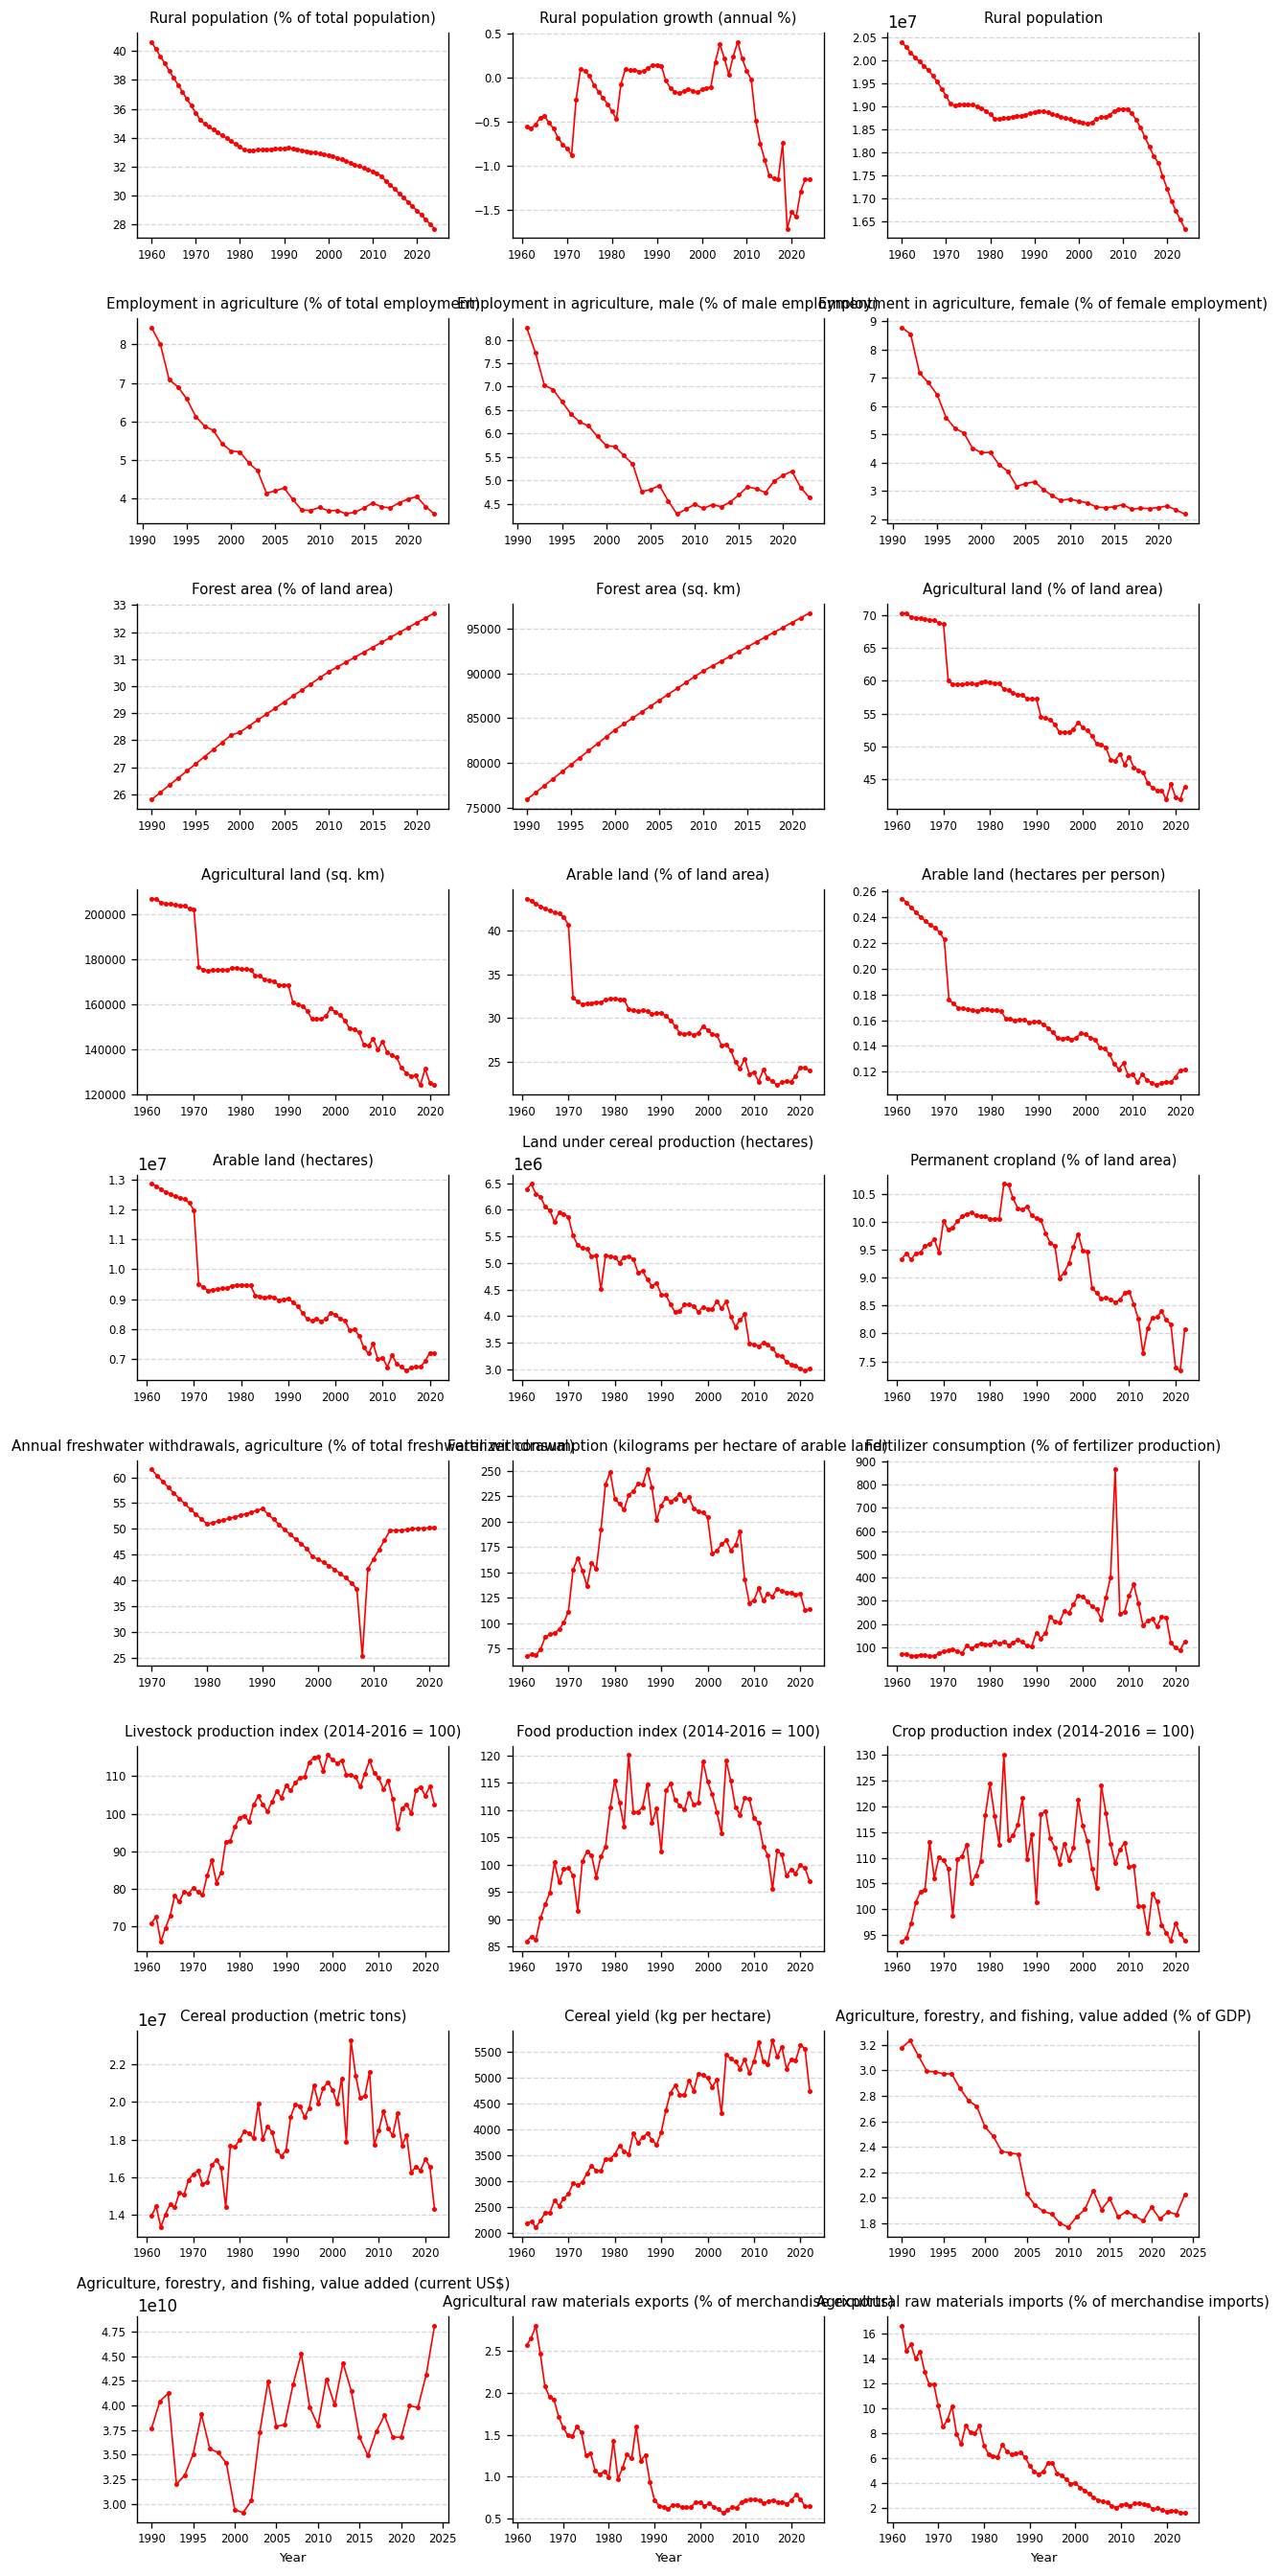

In [84]:
wide_df = prepare_wide_dataset(df)
wide_df.set_index('Year', inplace=True)
plot_timeseries(wide_df)

- stationary
- seasonality
- structural breaks

1. Do they make sense as causal relationships? <br> 
2. Do they fit established theory? <br>
3. Can you find a mechanism for causation? <br>
4. Is there a direct link, or are mediator variables involved? <br>

- [spurious correlation](https://statisticsbyjim.com/basics/spurious-correlation/): a spurious correlation occurs when two variables are correlated but don’t have a causal relationship. In other words, it appears like values of one variable cause changes in the other variable, but that’s not actually happening. 


In [ ]:
def prepare_differenced_dataset(wide_df):
    try:
        wide_df.set_index('Year', inplace=True)
    except:
        return Exception
    df_diff = wide_df.diff(periods=1)
    df_stationary = df_diff.dropna()
    return df_stationary

Creazione griglia 9x3 per 27 variabili


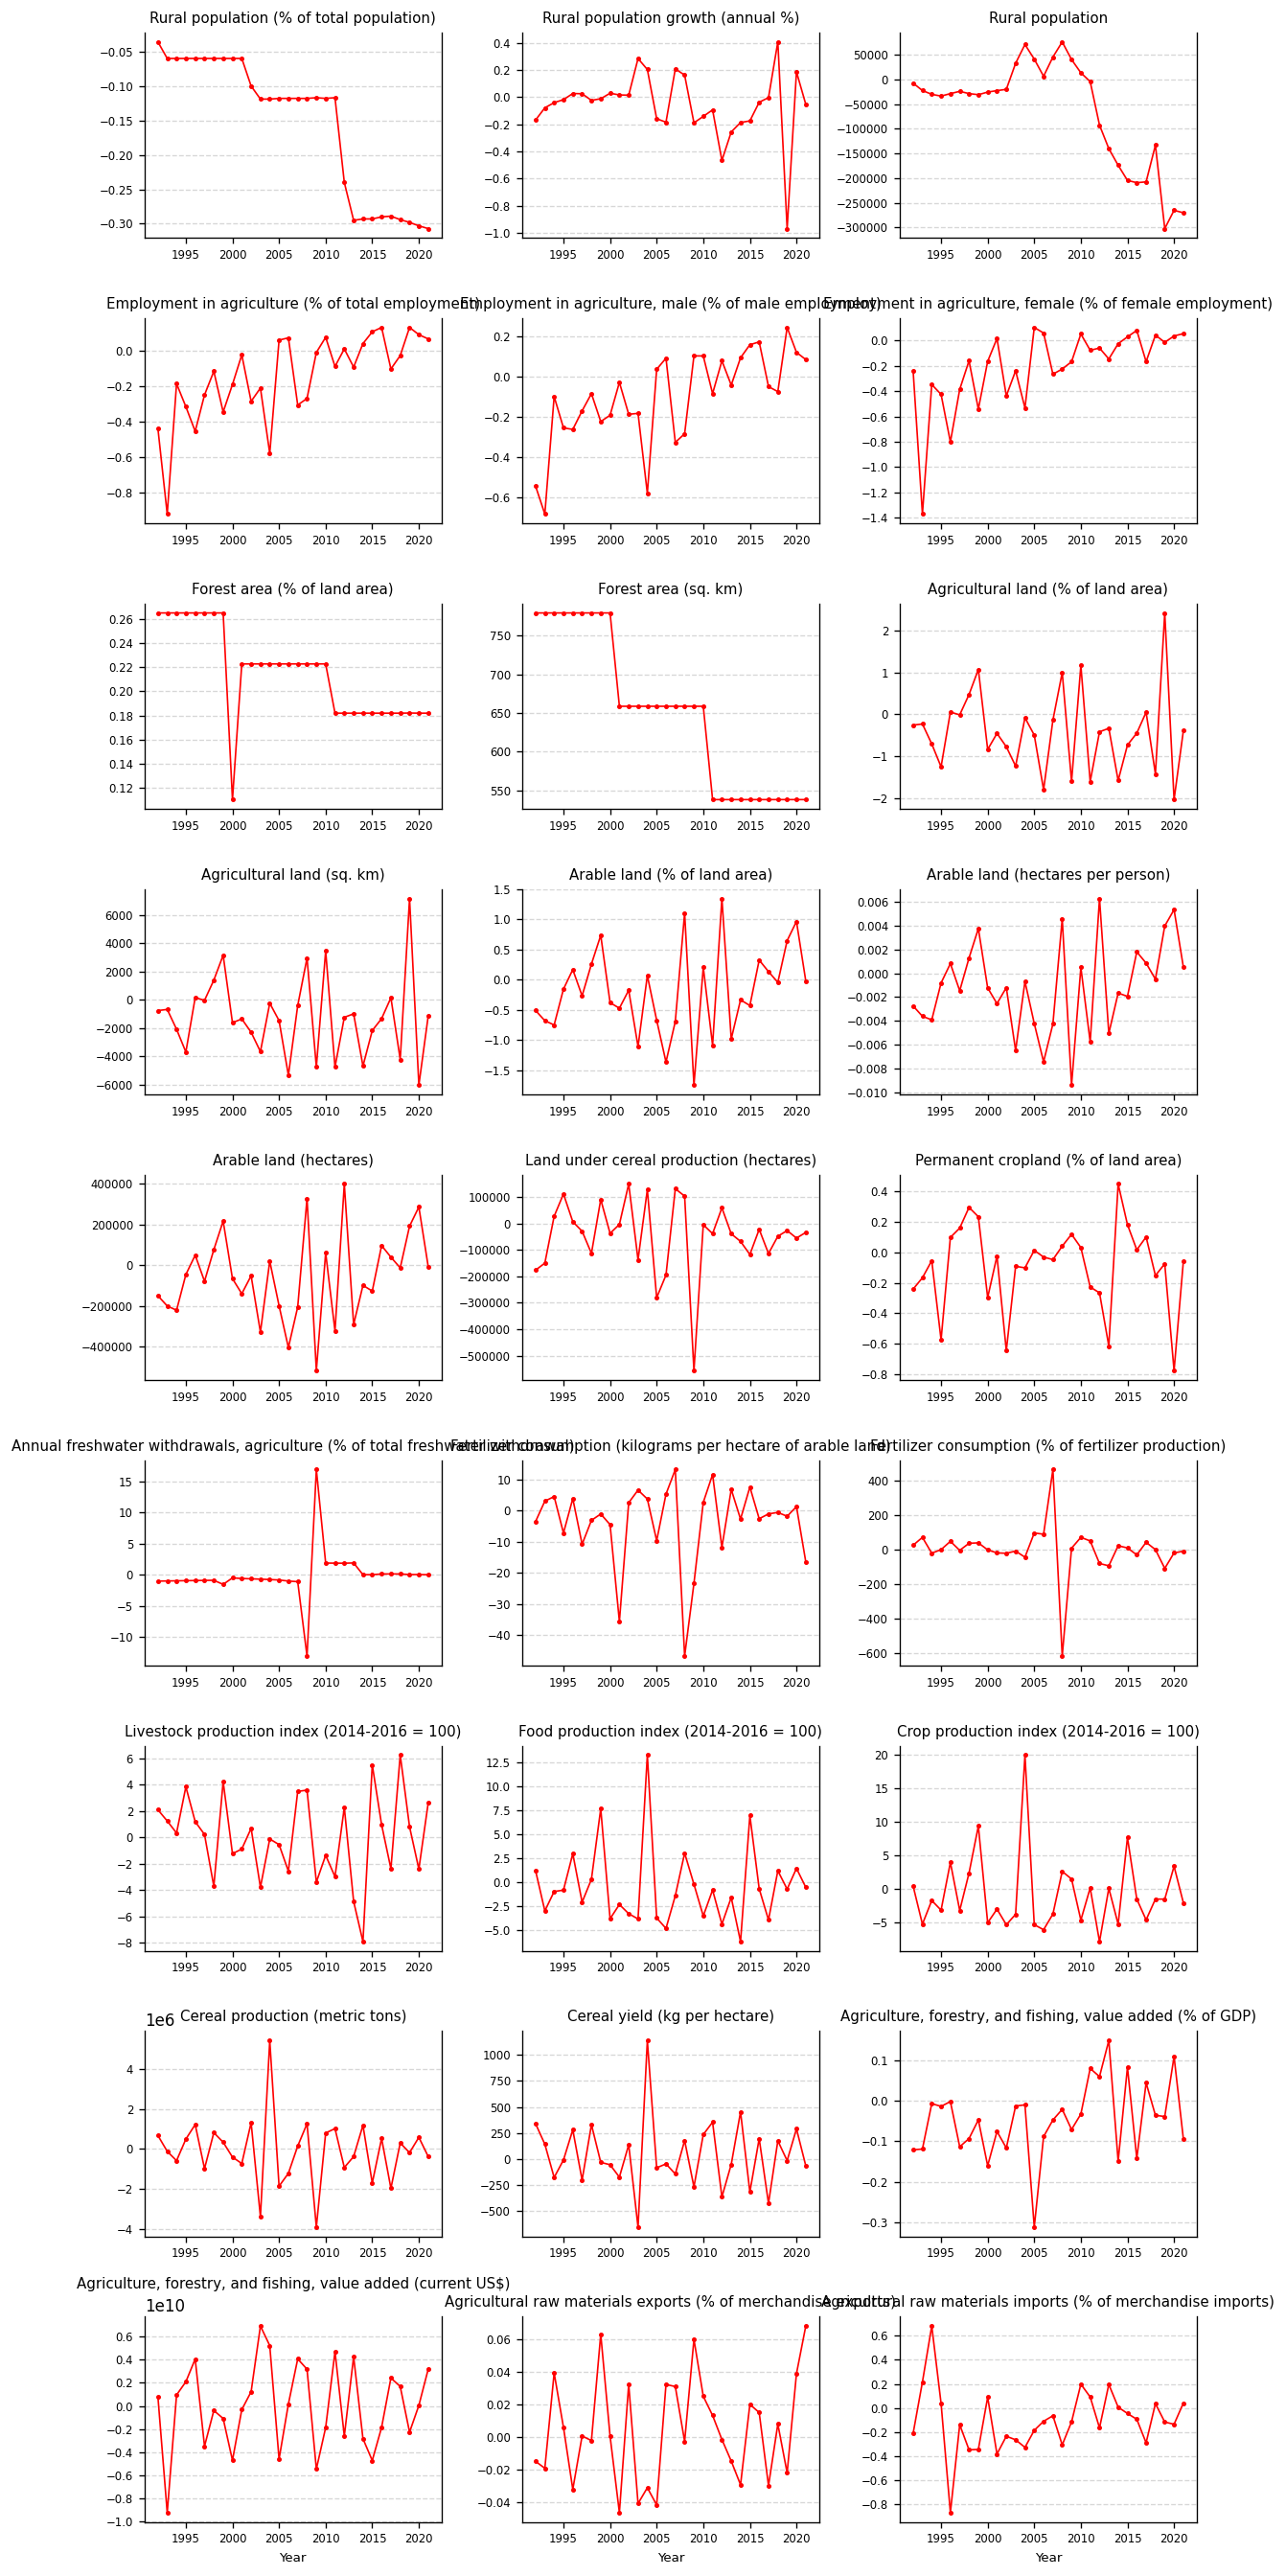

In [86]:
wide_diff_df = prepare_differenced_dataset(prepare_wide_dataset(df))
plot_timeseries(wide_diff_df)